In [1]:
import sys
sys.path.append("../code")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scale_bar import add_scalebar
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']

from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize

from scipy.io import savemat, loadmat

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)

from sklearn.datasets import make_moons

from scipy.spatial import procrustes

X_train = None
y_train = None

classes = ['Amacrine cells',
           'Astrocytes',
           'Bipolar cells',
           'Cones',
           'Fibroblasts',
           'Horizontal cells',
           'Microglia',
           'Muller glia',
           'Pericytes',
           'Retinal ganglion cells',
           'Rods',
           'Vascular endothelium']


#Torch Setups
from sklearn.decomposition import PCA

#import torch
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#X_torch = torch.as_tensor(X_train, dtype=torch.float32, device=device)

n_components = 2

def print_stats(X):
    print('size: ', X.shape)
    print('Mean:', np.mean(X))
    print('Max: ', np.max(X))
    print('Min: ', np.min(X))
    print('STD: ', np.std(X))
    
    return

#print('Training Statistics')
#print_stats(X_train)
#print('Test Statistics')
#print_stats(X_test)


epochs = 200
n_neighbors= 15
n_components = 2
MIN_DIST = 0.1

    
%matplotlib notebook
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(44808, 50) (44808,) float32
Training Statistics
size:  (44808, 50)
Mean: 3.4530467e-09
Max:  262.05157
Min:  -122.139206
STD:  3.7548966


In [2]:
from scale_bar import add_scalebar
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes
from matplotlib.offsetbox import HPacker, TextArea

def plot_idxs(array,idxs,title=None, values = None, tick_off=True):
    
    plt.figure()
    
    if title is not None:
        plt.title(title)
        
    n_plot = int(np.sqrt(len(idxs)))
    
    for i in range(n_plot**2):
        ax = plt.subplot(n_plot, n_plot, i+1)
        plt.scatter(array[idxs[i],:,0], array[idxs[i],:,1], c=y_train, s=0.01, cmap='Spectral')
        add_scalebar(ax, loc=4, barwidth=1, matchx=False, matchy=False, 
                     sizey=1, sizex=1, 
                     labelx='1.0', labely='1.0',
                    fontsize='xx-small',
                    hidex=True, hidey=True)
        
        
        if values is not None:
            val = r"$p_d=${:.3f}".format(values[i])
            plt.text(1.0, 1.0, val,
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
        if tick_off:
            plt.xticks([])
            plt.yticks([])
        plt.axis('on')
        
    return

def plot_low_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, k)[:k]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def plot_high_k_idxs(array, metric, k, title=None):

    idxs_arg = np.argpartition(metric, -k)[-k:]
    values = metric[idxs_arg]

    idxs_arg_pointer = np.argsort(values)

    values = values[idxs_arg_pointer]
    idxs_arg = idxs_arg[idxs_arg_pointer]

    plot_idxs(array, idxs_arg, title=title, values=values)
    
    return

def my_procrustes(data1, data2):
    #adapted from https://github.com/scipy/scipy/blob/v1.11.2/scipy/spatial/_procrustes.py#L15-L131
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)
    
    
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)
    
    mtx1 /= norm1
    mtx2 /= norm2
    
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s
    
    disparity = np.sum(np.square(mtx1 - mtx2))
    
    mtx2 = np.dot(data2, R.T) #just get the rotation, reflection - and no scaling
    
    
    return disparity, mtx2

def procrustes_distances(standard_array, array, verbose=True): 
    pds = []
    X_pdx = []

    for i in range(len(array)):
        d,x_pd = my_procrustes(standard_array, array[i])
        pds.append(d)
        X_pdx.append(x_pd)

    pds = np.array(pds)
    X_pdx = np.array(X_pdx)
    if verbose:
        print('Procrusted Distance: Mean: ', np.mean(pds), ' STD: ', np.std(pds))
    
    return pds, X_pdx

def procrustes_matrix(standard_array, array):
    diagonal, X_pdx = procrustes_distances(standard_array, array)
    
    N = len(array)
    pd_mat = np.zeros((N,N))
    
    for i in range(N):
        row, _ = procrustes_distances(array[i], array, verbose=False)
        pd_mat[i,:] = row
    
    #print(np.diag(pd_mat))
    
    for i in range(N):
        pd_mat[i,i] = diagonal[i]
        
    return pd_mat, X_pdx

In [3]:
fname = 'random_init_test_orig'

with open('random_init_test_orig/macosko_PCA_init.npy', 'rb') as f:
    umap_pca = np.load(f)
    
print(umap_pca.shape)

(44808, 2)


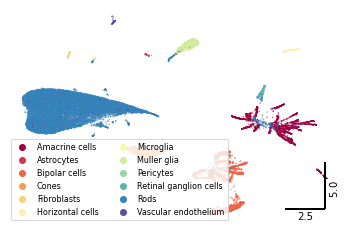

In [4]:
fig, ax = plt.subplots()

scatter = plt.scatter(umap_pca[:,0], umap_pca[:,1], c=y_train, s=0.1, alpha=1.0, cmap='Spectral')
plt.axis('off')

add_scalebar(ax, loc=4, barwidth=2)

lgd = plt.legend(*scatter.legend_elements(),
                    loc="lower left",
                    fontsize=20,
                 ncol=2,
                prop={'size': 8})
for j in range(len(lgd.get_texts())):
    lgd.get_texts()[j].set_text(classes[j])
    
plt.savefig('fig_random/standard_macosko_candle.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

<h1>Original UMAP</h1>

In [5]:
with open(fname+'/macosko_random_init.npy', 'rb') as f:
    umap_r1 = np.load(f)
    
print(umap_r1.shape)

pd_r1, umap_pd_r1 = procrustes_distances(umap_pca, umap_r1)

print(umap_pd_r1.shape)

pd_mat, X_pdx = procrustes_matrix(umap_pca, umap_r1)

(100, 44808, 2)
Procrusted Distance: Mean:  0.8539228141235883  STD:  0.08072328630379029
(100, 44808, 2)
Procrusted Distance: Mean:  0.8539228141235883  STD:  0.08072328630379029


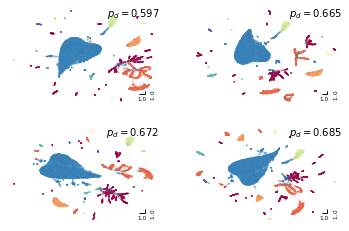

In [6]:
plot_low_k_idxs(umap_pd_r1,pd_r1,4)
plt.savefig('fig_random/macosko_umap_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [7]:
np.argsort(pd_r1)

array([21, 25, 67, 92, 64, 87, 78, 83, 19, 49, 23,  7,  6,  8, 14, 26, 95,
       53, 76, 85, 91, 63, 71, 89, 38, 55, 27, 51, 70, 17, 59, 29, 48, 84,
       28, 31, 65, 15, 50,  3, 33, 34,  9, 77, 22, 12, 58, 75, 41, 82, 73,
       86, 52, 45, 37, 13, 24, 11, 60, 68, 43,  2, 93, 44, 81, 99, 96, 46,
       61,  1, 80, 39, 94, 36, 62, 35, 72, 97, 56, 47, 54, 42,  0, 66, 88,
        5, 57, 79, 32, 16, 69, 10, 20, 18,  4, 74, 40, 98, 90, 30])

[0.59699408 0.6652677  0.67201546 0.68460157 0.69328429 0.70319087
 0.70703316 0.72367585 0.72428484 0.74010119 0.74359506 0.76154689
 0.7639433  0.76676865 0.77313202 0.78013442 0.78173231 0.78567043
 0.79059706 0.79145665 0.79264736 0.7942395  0.79545738 0.79568565
 0.7979071  0.80085511 0.8086775  0.80987844 0.81145968 0.81207083
 0.8125038  0.81431992 0.81494296 0.81679578 0.81945499 0.82578954
 0.83666252 0.83755151 0.83792499 0.83872607 0.84114385 0.84271087
 0.84340653 0.85158776 0.85463237 0.85772878 0.85798913 0.86500648
 0.8661316  0.8669715  0.86862032 0.86904226 0.87242545 0.87326134
 0.87504217 0.87587586 0.87646236 0.87898521 0.88269489 0.88348292
 0.88393105 0.88487252 0.88751017 0.88885201 0.88988514 0.89473752
 0.89675692 0.89816453 0.89858184 0.9004292  0.90161354 0.90473035
 0.90611166 0.9088101  0.91305508 0.91418169 0.91763554 0.92096552
 0.92316741 0.92457753 0.92672321 0.9355967  0.93560394 0.93601053
 0.9394885  0.94536759 0.94539806 0.9472493  0.9494712  0.9532

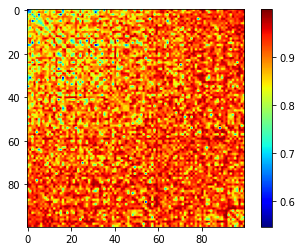

In [8]:
idx = np.argsort(np.diag(pd_mat))
pd_mat_2 = pd_mat[idx,:][:,idx]

plt.figure()
plt.imshow(pd_mat_2, cmap='jet')
plt.colorbar()

print(np.diag(pd_mat_2))

<h1>Modified Method</h1>

In [9]:
with open(fname+'/macosko_random_init_model_1_0.5v2.npy', 'rb') as f:
    umap_mod = np.load(f)
    
print(umap_mod.shape)

pd_mod, umap_pd_mod = procrustes_distances(umap_pca, umap_mod)

print(umap_pd_mod.shape)

pd_mat_mod, X_pdx_mod = procrustes_matrix(umap_pca, umap_mod)

(100, 44808, 2)
Procrusted Distance: Mean:  0.5376831919777577  STD:  0.11444385671624419
(100, 44808, 2)
Procrusted Distance: Mean:  0.5376831919777577  STD:  0.11444385671624419


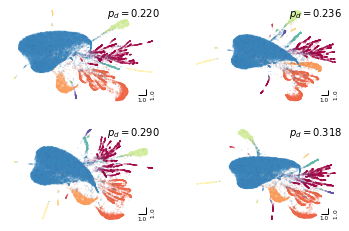

In [10]:
plot_low_k_idxs(umap_pd_mod,pd_mod,4)

plt.savefig('fig_random/macosko_umap_mod_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [11]:
np.argsort(pd_mod)

array([92, 21, 53, 29, 71, 26, 90, 14, 93, 32, 99, 24, 91, 48, 41, 12, 81,
       77, 22, 36, 31, 60, 13, 38, 15, 19, 79, 52, 67, 73, 46, 75, 72, 63,
       64, 25, 89, 61, 17, 65, 66, 80, 98, 33, 50, 58, 23, 56, 47, 74, 84,
       40, 39, 27, 96,  5, 94,  0, 82, 42, 95,  3, 20, 70, 35, 97, 49,  4,
       44, 28, 34, 69,  6, 51, 86, 45,  7, 62,  2, 68, 87, 59, 55, 83, 10,
        8, 16,  1, 43, 76, 85, 78,  9, 57, 37, 11, 18, 88, 30, 54])

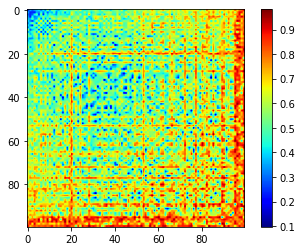

In [12]:
idx_mod = np.argsort(np.diag(pd_mat_mod))
pd_mat_2_mod = pd_mat_mod[idx_mod,:][:,idx_mod]

plt.figure()
plt.imshow(pd_mat_2_mod, cmap='jet')
plt.colorbar()

<h1>Composite Mod</h1>

In [13]:
with open(fname+'/macosko_random_init_model_1_composite_v2.npy', 'rb') as f:
    umap_com = np.load(f)
    
print(umap_com.shape)

pd_com, umap_pd_com = procrustes_distances(umap_pca, umap_com)

print(umap_pd_com.shape)

pd_mat_com, X_pdx_com = procrustes_matrix(umap_pca, umap_com)

(100, 44808, 2)
Procrusted Distance: Mean:  0.5294091438404694  STD:  0.14879318206238437
(100, 44808, 2)
Procrusted Distance: Mean:  0.5294091438404694  STD:  0.14879318206238437


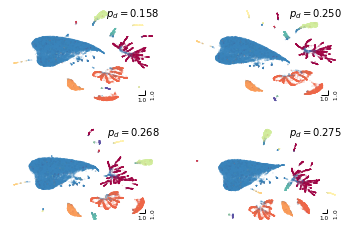

In [14]:
plot_low_k_idxs(umap_pd_com,pd_com,4)

plt.savefig('fig_random/macosko_umap_com_random.png', dpi=400, bbox_inches='tight', pad_inches=0.4)

In [15]:
np.argsort(pd_com)

array([61, 23, 87, 18, 27, 21,  2, 13, 28, 26, 35,  1, 92, 81,  7, 86,  6,
       84,  0, 19, 41, 38, 29, 99, 37, 53, 69, 68, 77, 10, 91, 16, 25, 55,
       58, 63, 54, 15, 65, 46, 33, 60, 78, 93, 40, 80, 82, 62, 64, 66,  4,
       72, 98, 89, 39, 71, 97, 85, 75, 12, 34, 96, 94, 59, 49, 67, 24,  5,
       22, 14, 11, 48, 45,  8, 79, 95, 73, 52, 43, 74, 32, 70, 51,  3,  9,
       76, 50, 30, 57, 31, 20, 83, 88, 36, 90, 44, 47, 42, 17, 56])

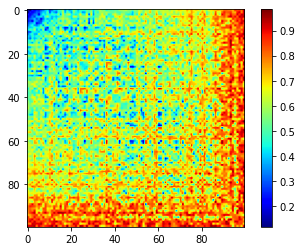

In [16]:
idx_com = np.argsort(np.diag(pd_mat_com))
pd_mat_2_com = pd_mat_com[idx_com,:][:,idx_com]

plt.figure()
plt.imshow(pd_mat_2_com, cmap='jet')
plt.colorbar()

In [17]:
min_val = np.floor(np.min(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))
max_val = np.ceil(np.max(np.concatenate((pd_mat_2,pd_mat_2_mod,pd_mat_2_com))))

In [18]:
cmap = plt.cm.jet
norm = plt.Normalize(vmin=min_val, vmax=max_val)

pd_mat_2_image = cmap(norm(pd_mat_2))

print(pd_mat_2_image.shape)

plt.imsave('fig_random/macosko_umap_random_pdmat.eps', pd_mat_2_image)

pd_mat_2_mod_image = cmap(norm(pd_mat_2_mod))
plt.imsave('fig_random/macosko_umap_mod_random_pdmat.eps', pd_mat_2_mod_image)

pd_mat_2_com_image = cmap(norm(pd_mat_2_com))
plt.imsave('fig_random/macosko_umap_com_random_pdmat.eps', pd_mat_2_com_image)


(100, 100, 4)


In [19]:
pd_mat_3 = pd_mat_2.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Original UMAP: ', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_mod.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Modified UMAP:', np.mean(z), np.std(z))

pd_mat_3 = pd_mat_2_com.copy()
np.fill_diagonal(pd_mat_3, 0)
z = pd_mat_3[pd_mat_3>0]
print('Composite UMAP: ', np.mean(z), np.std(z))


Original UMAP:  0.9052932199182468 0.06254296364495142
Modified UMAP: 0.6069455851021858 0.16105841965936607
Composite UMAP:  0.6446750385507699 0.15407652471494615


<h1>Colorbar</h1>

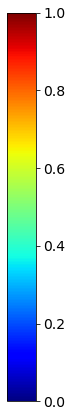

In [20]:
import pylab as pl
import numpy as np

a = np.array([[min_val,max_val]])
pl.figure(figsize=(0.5, 9))
img = pl.imshow(a, cmap="jet")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.2, 0.8, 0.6])
cb = pl.colorbar(orientation="vertical", cax=cax)
#pl.savefig("colorbar.pdf")
cb.ax.tick_params(labelsize=14)
pl.savefig("fig_random/colorbar.svg", dpi=400, bbox_inches='tight')

In [21]:
print(min_val)

print(max_val)

0.0
1.0


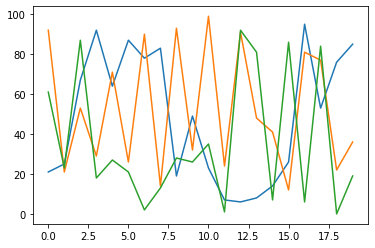

In [22]:
plt.figure()
plt.plot(np.argsort(pd_r1)[:20])
plt.plot(np.argsort(pd_mod)[:20])
plt.plot(np.argsort(pd_com)[:20])